## Stage 1: import dataset + libraries

In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import Dataset
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))
from data import Preprocessing, FeatureExtraction

In [2]:
prepro_tool = Preprocessing()
train_df = prepro_tool.read_CSV(file_name='train.csv')
test_df = prepro_tool.read_CSV(file_name='test.csv')

train_df.shape, test_df.shape

((27480, 10), (3534, 9))

## Stage 2: Preprocessing

In [3]:
train_data = Dataset.from_pandas(train_df)
test_data = Dataset.from_pandas(test_df)

train_data[0]

{'textID': 'cb774db0d1',
 'text': ' I`d have responded, if I were going',
 'selected_text': 'I`d have responded, if I were going',
 'sentiment': 'neutral',
 'Time of Tweet': 'morning',
 'Age of User': '0-20',
 'Country': 'Afghanistan',
 'Population -2020': 38928346,
 'Land Area (Km²)': 652860.0,
 'Density (P/Km²)': 60,
 '__index_level_0__': 0}

In [4]:
train_data = train_data.map(lambda ex: {'processed_text': prepro_tool.preprocess(ex['text']),\
                                        'label': 2 if ex['sentiment'] == 'positive' else \
                                        1 if ex['sentiment'] == 'neutral' else 0 })
test_data = test_data.map(lambda ex: {'processed_text': prepro_tool.preprocess(ex['text']),\
                                        'label': 2 if ex['sentiment'] == 'positive' else \
                                        1 if ex['sentiment'] == 'neutral' else 0 })

train_data[0]

Map:   0%|          | 0/27480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

{'textID': 'cb774db0d1',
 'text': ' I`d have responded, if I were going',
 'selected_text': 'I`d have responded, if I were going',
 'sentiment': 'neutral',
 'Time of Tweet': 'morning',
 'Age of User': '0-20',
 'Country': 'Afghanistan',
 'Population -2020': 38928346,
 'Land Area (Km²)': 652860.0,
 'Density (P/Km²)': 60,
 '__index_level_0__': 0,
 'processed_text': 'id responded going',
 'label': 1}

In [5]:
test_data[0]

{'textID': 'f87dea47db',
 'text': 'Last session of the day  http://twitpic.com/67ezh',
 'sentiment': 'neutral',
 'Time of Tweet': 'morning',
 'Age of User': '0-20',
 'Country': 'Afghanistan',
 'Population -2020': 38928346.0,
 'Land Area (Km²)': 652860.0,
 'Density (P/Km²)': 60.0,
 '__index_level_0__': 0,
 'processed_text': 'last session day httptwitpiccomezh',
 'label': 1}

### Load number of samples for each class

/var/folders/cy/hxjg9r351_99ytx8k04pq_4c0000gn/T/ipykernel_1797/3149057442.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


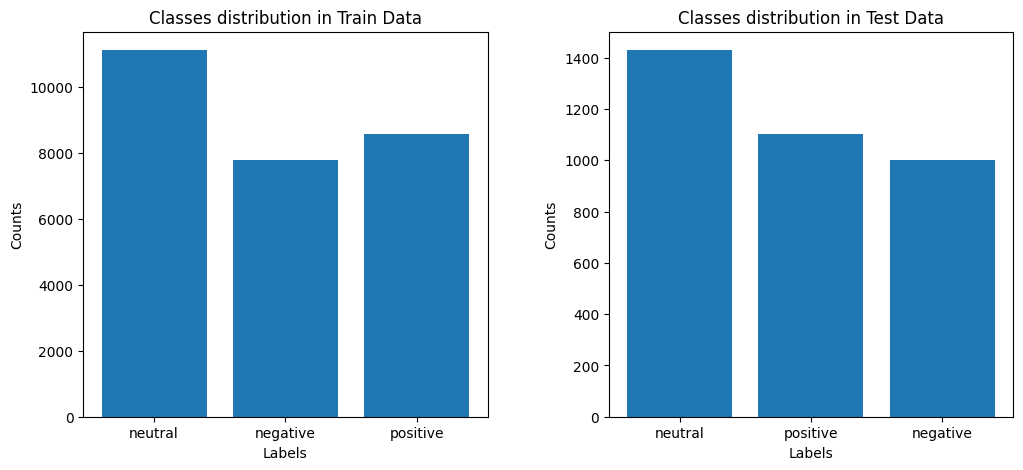

In [11]:
from typing import Counter
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'wspace': 0.3})

counter = Counter(train_data['sentiment'])
axs[0].bar(counter.keys(), counter.values())
axs[0].set_title("Classes distribution in Train Data")
axs[0].set_xlabel("Labels")
axs[0].set_ylabel("Counts")

counter = Counter(test_data['sentiment'])
axs[1].bar(counter.keys(), counter.values())
axs[1].set_title("Classes distribution in Test Data")
axs[1].set_xlabel("Labels")
axs[1].set_ylabel("Counts")

plt.tight_layout()
plt.show()

### Map tf-idf feature to dataset

In [12]:
extractor = TfidfVectorizer(ngram_range=(1,3), max_features=50000)
extractor.fit(train_data['processed_text'])
train_tf_idf_feature = extractor.transform(train_data['processed_text']).toarray()
test_tf_idf_feature = extractor.transform(test_data['processed_text']).toarray()

print(f"train tf-idf shape: ({len(train_tf_idf_feature)}, {len(train_tf_idf_feature[0])})")
print(f"test tf-idf shape: ({len(test_tf_idf_feature)}, {len(test_tf_idf_feature[0])})")

def add_tf_idf(example, idx, tf_idf_feature):
    return {'tf_idf': tf_idf_feature[idx]}

train_data = train_data.map(add_tf_idf, with_indices=True, fn_kwargs={'tf_idf_feature': train_tf_idf_feature})
test_data = test_data.map(add_tf_idf, with_indices=True, fn_kwargs={'tf_idf_feature': test_tf_idf_feature})
train_data[0]

train tf-idf shape: (27480, 50000)
test tf-idf shape: (3534, 50000)


Map:   0%|          | 0/27480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

{'textID': 'cb774db0d1',
 'text': ' I`d have responded, if I were going',
 'selected_text': 'I`d have responded, if I were going',
 'sentiment': 'neutral',
 'Time of Tweet': 'morning',
 'Age of User': '0-20',
 'Country': 'Afghanistan',
 'Population -2020': 38928346,
 'Land Area (Km²)': 652860.0,
 'Density (P/Km²)': 60,
 '__index_level_0__': 0,
 'processed_text': 'id responded going',
 'label': 1,
 'tf_idf': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")
train_data.set_format(type="torch", columns=['tf_idf', 'label'])
test_data.set_format(type="torch", columns=['tf_idf', 'label'])
train_data[0]

device: cpu


{'label': tensor(1), 'tf_idf': tensor([0., 0., 0.,  ..., 0., 0., 0.])}

### Split data into train and valid set

In [14]:
train_dict = Dataset.train_test_split(train_data, test_size=0.2, shuffle=True, seed=2025)
train_data = train_dict['train']
valid_data = train_dict['test']

train_data.shape, valid_data.shape, test_data.shape

((21984, 14), (5496, 14), (3534, 13))

## Step 3: Build Model

- We build a simple Logistic Regression model using neural network block from **torch**.

In [19]:
class LogisticReg(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):       # X shape: (N, input_size) => (N, output_size)
        X = self.fc(X)
        X = self.relu(X)
        return self.softmax(X)

## Step 4: Training model

### Define model hyperparameter

In [16]:
learning_rate = 1e-3
batch_size = 32
num_epochs = 20
stop_iter = 3

### Load data into batch

In [17]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

len(train_loader), len(valid_loader), len(test_loader)

(687, 172, 111)

In [20]:
input_size = list(train_data[0]['tf_idf'].size())[0]
output_size = 3

torch.manual_seed(2025)
model = LogisticReg(input_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criteria = nn.CrossEntropyLoss()
model.to(device)

LogisticReg(
  (fc): Linear(in_features=50000, out_features=3, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [ ]:
def train_fn(model, loader, epoch):
    model.train()
    epoch_loss = 0
    for batch in tqdm(loader, desc=f"Epoch {epoch} training"):
        input = batch['tf_idf'].to(device)
        label = batch['label'].to(device)
        output = model(input)

        loss = criteria(output, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss
    
    print(f"Train loss at epoch {epoch}: {(epoch_loss / len(loader)):.3f}\n---")
    return epoch_loss / len(loader)


def accuracy_eval(outputs, labels):
    predictions = np.argmax(outputs, axis=1)
    return accuracy_score(labels, predictions)


def f1_score_eval(outputs, labels):
    predictions = np.argmax(outputs, axis=1)
    return f1_score(labels, predictions, average='weighted')


def evaluate_fn(model, loader, name, returned_predictions=False):
    """
    if returned_predictions is True, return the predictions and labels
    else return the accuracy and f1 score
    """
    model.eval()
    valid_loss = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Evaluating on {name.lower()} data"):
            input = batch['tf_idf'].to(device)
            label = batch['label'].to(device)
            output = model(input)

            loss = criteria(output, label)
            valid_loss += loss

            all_outputs.extend(output.detach().cpu().numpy())
            all_labels.extend(label.detach().cpu().numpy())
    
    if returned_predictions:
        return np.array(all_outputs), np.array(all_labels)
        
    acc_score = accuracy_eval(all_outputs, all_labels)
    f1_score = f1_score_eval(all_outputs, all_labels)
    print(f"{name} loss: {(valid_loss / len(loader)):.3f} | {name} accuracy: {acc_score:.3f} | {name} F1-score: {f1_score:.3f}\n---\n")
    return acc_score, f1_score

In [16]:
best_score = float("-inf")
patient = 3

train_losses = []
valid_acc_scores = []

for epoch in range(num_epochs):
    train_loss = train_fn(model, train_loader, epoch+1)
    acc_score, _ = evaluate_fn(model, valid_loader, "Valid")
    test_acc, test_f1 = evaluate_fn(model, test_loader, "Test")

    train_losses.append(train_loss)
    valid_acc_scores.append(acc_score)

    if acc_score > best_score:
        best_score = acc_score
        torch.save(model.state_dict(), "ME-model.pt")
        patient = 3
        print(f"Save model successfully")
    else:
        patient -= 1
        if patient <= 0:
            print(f"Early stopping at epoch: {epoch}")
            break

Epoch 1 training: 100%|██████████| 687/687 [00:09<00:00, 74.04it/s]


Train loss at epoch 1: 1.085
---


Evaluating on valid data: 100%|██████████| 172/172 [00:02<00:00, 59.04it/s]


Valid loss: 1.072 | Valid accuracy: 0.484 | Valid F1-score: 0.381
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 58.61it/s]


Test loss: 1.070 | Test accuracy: 0.493 | Test F1-score: 0.403
---

Save model successfully


Epoch 2 training: 100%|██████████| 687/687 [00:15<00:00, 45.32it/s]


Train loss at epoch 2: 1.053
---


Evaluating on valid data: 100%|██████████| 172/172 [00:03<00:00, 57.16it/s]


Valid loss: 1.050 | Valid accuracy: 0.529 | Valid F1-score: 0.458
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 61.78it/s]


Test loss: 1.047 | Test accuracy: 0.545 | Test F1-score: 0.488
---

Save model successfully


Epoch 3 training: 100%|██████████| 687/687 [00:14<00:00, 47.92it/s]


Train loss at epoch 3: 1.023
---


Evaluating on valid data: 100%|██████████| 172/172 [00:03<00:00, 56.91it/s]


Valid loss: 1.032 | Valid accuracy: 0.577 | Valid F1-score: 0.535
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 63.70it/s]


Test loss: 1.027 | Test accuracy: 0.596 | Test F1-score: 0.567
---

Save model successfully


Epoch 4 training: 100%|██████████| 687/687 [00:13<00:00, 52.38it/s]


Train loss at epoch 4: 0.995
---


Evaluating on valid data: 100%|██████████| 172/172 [00:03<00:00, 53.33it/s]


Valid loss: 1.017 | Valid accuracy: 0.613 | Valid F1-score: 0.590
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 63.93it/s]


Test loss: 1.010 | Test accuracy: 0.629 | Test F1-score: 0.615
---

Save model successfully


Epoch 5 training: 100%|██████████| 687/687 [00:14<00:00, 47.22it/s]


Train loss at epoch 5: 0.970
---


Evaluating on valid data: 100%|██████████| 172/172 [00:03<00:00, 48.38it/s]


Valid loss: 1.003 | Valid accuracy: 0.630 | Valid F1-score: 0.616
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 56.69it/s]


Test loss: 0.995 | Test accuracy: 0.642 | Test F1-score: 0.635
---

Save model successfully


Epoch 6 training: 100%|██████████| 687/687 [00:12<00:00, 53.95it/s]


Train loss at epoch 6: 0.947
---


Evaluating on valid data: 100%|██████████| 172/172 [00:02<00:00, 60.51it/s]


Valid loss: 0.991 | Valid accuracy: 0.645 | Valid F1-score: 0.635
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 65.85it/s]


Test loss: 0.982 | Test accuracy: 0.658 | Test F1-score: 0.653
---

Save model successfully


Epoch 7 training: 100%|██████████| 687/687 [00:12<00:00, 53.20it/s]


Train loss at epoch 7: 0.926
---


Evaluating on valid data: 100%|██████████| 172/172 [00:02<00:00, 59.53it/s]


Valid loss: 0.981 | Valid accuracy: 0.655 | Valid F1-score: 0.649
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 64.48it/s]


Test loss: 0.970 | Test accuracy: 0.671 | Test F1-score: 0.669
---

Save model successfully


Epoch 8 training: 100%|██████████| 687/687 [00:12<00:00, 54.53it/s]


Train loss at epoch 8: 0.907
---


Evaluating on valid data: 100%|██████████| 172/172 [00:02<00:00, 59.43it/s]


Valid loss: 0.971 | Valid accuracy: 0.662 | Valid F1-score: 0.657
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 64.30it/s]


Test loss: 0.960 | Test accuracy: 0.675 | Test F1-score: 0.674
---

Save model successfully


Epoch 9 training: 100%|██████████| 687/687 [00:12<00:00, 54.47it/s]


Train loss at epoch 9: 0.890
---


Evaluating on valid data: 100%|██████████| 172/172 [00:02<00:00, 60.83it/s]


Valid loss: 0.963 | Valid accuracy: 0.666 | Valid F1-score: 0.663
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 62.61it/s]


Test loss: 0.951 | Test accuracy: 0.682 | Test F1-score: 0.682
---

Save model successfully


Epoch 10 training: 100%|██████████| 687/687 [00:12<00:00, 55.18it/s]


Train loss at epoch 10: 0.874
---


Evaluating on valid data: 100%|██████████| 172/172 [00:02<00:00, 61.24it/s]


Valid loss: 0.956 | Valid accuracy: 0.668 | Valid F1-score: 0.666
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 64.57it/s]


Test loss: 0.944 | Test accuracy: 0.680 | Test F1-score: 0.680
---

Save model successfully


Epoch 11 training: 100%|██████████| 687/687 [00:12<00:00, 54.65it/s]


Train loss at epoch 11: 0.860
---


Evaluating on valid data: 100%|██████████| 172/172 [00:02<00:00, 61.31it/s]


Valid loss: 0.950 | Valid accuracy: 0.670 | Valid F1-score: 0.668
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 62.26it/s]


Test loss: 0.937 | Test accuracy: 0.681 | Test F1-score: 0.681
---

Save model successfully


Epoch 12 training: 100%|██████████| 687/687 [00:12<00:00, 54.88it/s]


Train loss at epoch 12: 0.847
---


Evaluating on valid data: 100%|██████████| 172/172 [00:02<00:00, 58.44it/s]


Valid loss: 0.944 | Valid accuracy: 0.672 | Valid F1-score: 0.671
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 64.68it/s]


Test loss: 0.933 | Test accuracy: 0.678 | Test F1-score: 0.679
---

Save model successfully


Epoch 13 training: 100%|██████████| 687/687 [06:10<00:00,  1.85it/s]  


Train loss at epoch 13: 0.834
---


Evaluating on valid data: 100%|██████████| 172/172 [00:03<00:00, 55.43it/s]


Valid loss: 0.939 | Valid accuracy: 0.674 | Valid F1-score: 0.672
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 59.98it/s]


Test loss: 0.927 | Test accuracy: 0.677 | Test F1-score: 0.678
---

Save model successfully


Epoch 14 training: 100%|██████████| 687/687 [00:14<00:00, 47.91it/s]


Train loss at epoch 14: 0.823
---


Evaluating on valid data: 100%|██████████| 172/172 [00:02<00:00, 58.26it/s]


Valid loss: 0.935 | Valid accuracy: 0.672 | Valid F1-score: 0.672
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 58.50it/s]


Test loss: 0.922 | Test accuracy: 0.677 | Test F1-score: 0.678
---



Epoch 15 training: 100%|██████████| 687/687 [00:14<00:00, 46.17it/s]


Train loss at epoch 15: 0.813
---


Evaluating on valid data: 100%|██████████| 172/172 [00:05<00:00, 30.11it/s]


Valid loss: 0.931 | Valid accuracy: 0.675 | Valid F1-score: 0.674
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 56.29it/s]


Test loss: 0.918 | Test accuracy: 0.678 | Test F1-score: 0.679
---

Save model successfully


Epoch 16 training: 100%|██████████| 687/687 [00:13<00:00, 49.37it/s]


Train loss at epoch 16: 0.803
---


Evaluating on valid data: 100%|██████████| 172/172 [00:02<00:00, 57.60it/s]


Valid loss: 0.927 | Valid accuracy: 0.675 | Valid F1-score: 0.674
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 60.70it/s]


Test loss: 0.915 | Test accuracy: 0.678 | Test F1-score: 0.679
---

Save model successfully


Epoch 17 training: 100%|██████████| 687/687 [00:13<00:00, 51.52it/s]


Train loss at epoch 17: 0.794
---


Evaluating on valid data: 100%|██████████| 172/172 [00:03<00:00, 51.14it/s]


Valid loss: 0.924 | Valid accuracy: 0.674 | Valid F1-score: 0.674
---



Evaluating on test data: 100%|██████████| 111/111 [00:02<00:00, 44.10it/s]


Test loss: 0.912 | Test accuracy: 0.679 | Test F1-score: 0.680
---



Epoch 18 training: 100%|██████████| 687/687 [00:16<00:00, 40.64it/s]


Train loss at epoch 18: 0.785
---


Evaluating on valid data: 100%|██████████| 172/172 [00:03<00:00, 51.51it/s]


Valid loss: 0.921 | Valid accuracy: 0.675 | Valid F1-score: 0.675
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 58.87it/s]


Test loss: 0.909 | Test accuracy: 0.678 | Test F1-score: 0.679
---



Epoch 19 training: 100%|██████████| 687/687 [00:13<00:00, 50.92it/s]


Train loss at epoch 19: 0.777
---


Evaluating on valid data: 100%|██████████| 172/172 [00:03<00:00, 55.25it/s]


Valid loss: 0.919 | Valid accuracy: 0.675 | Valid F1-score: 0.675
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 57.30it/s]


Test loss: 0.907 | Test accuracy: 0.680 | Test F1-score: 0.681
---

Save model successfully


Epoch 20 training: 100%|██████████| 687/687 [00:13<00:00, 51.55it/s]


Train loss at epoch 20: 0.770
---


Evaluating on valid data: 100%|██████████| 172/172 [00:03<00:00, 57.20it/s]


Valid loss: 0.917 | Valid accuracy: 0.675 | Valid F1-score: 0.675
---



Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 58.80it/s]

Test loss: 0.905 | Test accuracy: 0.680 | Test F1-score: 0.681
---



## Step 4: Model evaluation

### Load best model

In [22]:
model.load_state_dict(torch.load("ME-model.pt", weights_only=True))

<All keys matched successfully>

### Compute accuracy & F1-Score

In [23]:
evaluate_fn(model, test_loader, "Test")

Evaluating on test data: 100%|██████████| 111/111 [00:01<00:00, 93.33it/s]


Test loss: 0.907 | Test accuracy: 0.680 | Test F1-score: 0.681
---



(0.6796830786644029, 0.6807363561190508)

In [ ]:
train_losses = [loss.detach().cpu().numpy() for loss in train_losses]

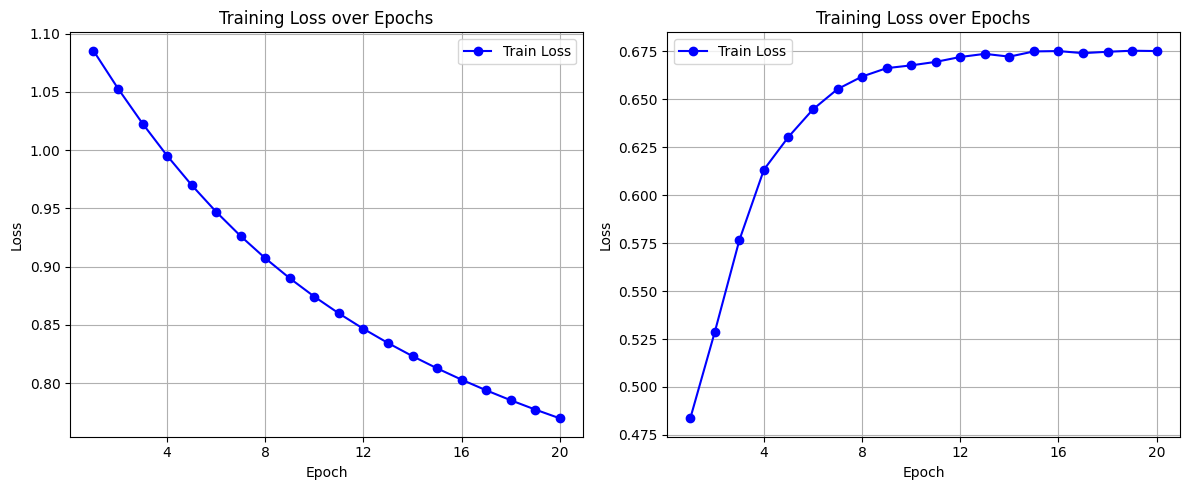

In [ ]:
epochs = list(range(1, 21))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(epochs, train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss over Epochs")
axes[0].grid(True)
axes[0].legend()
axes[0].set_xticks([epoch for epoch in epochs if epoch % 4 == 0])

axes[1].plot(epochs, valid_acc_scores, marker='o', linestyle='-', color='b', label='Evaluation Accuracy')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Evaluation Accuracy over Epochs")
axes[1].grid(True)
axes[1].legend()
axes[1].set_xticks([epoch for epoch in epochs if epoch % 4 == 0])

plt.tight_layout()
plt.show()

### Draw AUC - ROC curves

Evaluating on test data: 100%|██████████| 111/111 [00:00<00:00, 146.65it/s]


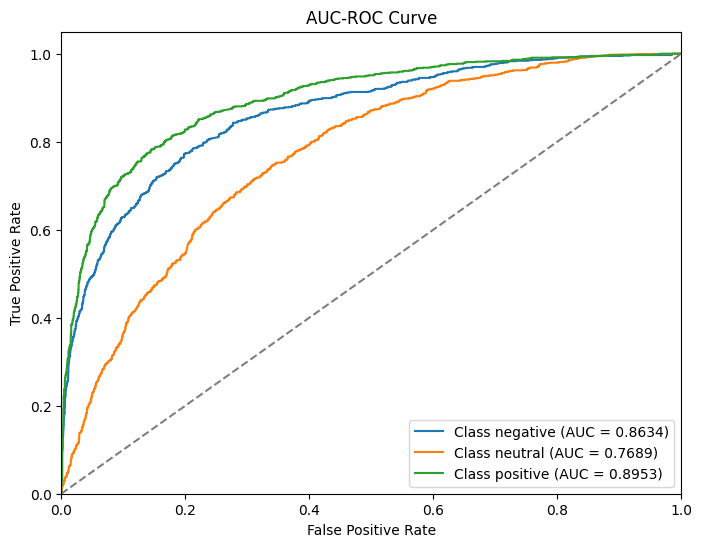

In [38]:
from visualization import plot_roc_auc, plot_confusion_matrix

y_prob, y_true = evaluate_fn(model, test_loader, "Test", returned_predictions=True)
y_pred = np.argmax(y_prob, axis=1)
y_prob.shape, y_true.shape, y_pred.shape

plot_roc_auc(y_true, y_prob, classes=['negative', 'neutral', 'positive'])

### Plot confusion matrix

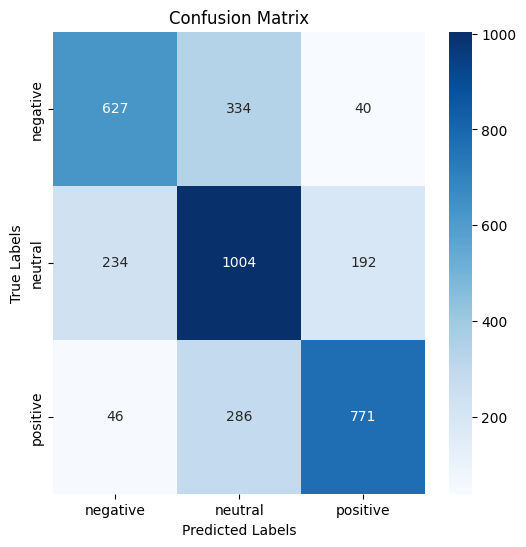

In [39]:
plot_confusion_matrix(y_true, y_pred, class_labels=['negative', 'neutral', 'positive'])